In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
player_stats = pd.read_csv("merged_df.csv")

8557


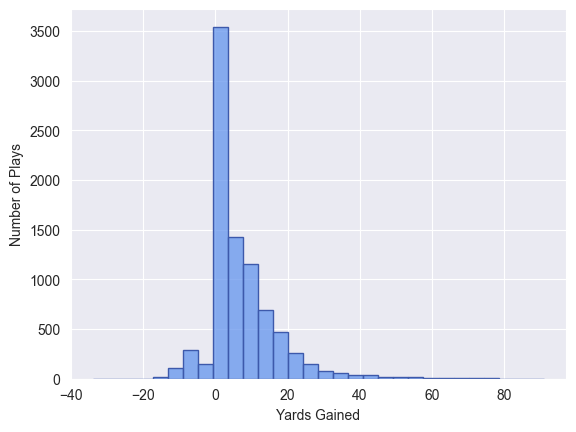

In [34]:
play_data2021 = pd.read_csv("./data2023/plays.csv")
print(len(play_data2021))
histplot = sns.histplot(play_data2021["prePenaltyPlayResult"], bins=30, color='#6495ED', edgecolor='#3D59AB')  # density=False would make counts
sns.set_style("darkgrid")
fig = histplot.get_figure()
plt.ylabel('Number of Plays')
plt.xlabel('Yards Gained')
fig.savefig("YardsGainedHistogram.png") 

In [4]:
play_data2018 = pd.read_csv("../BigDataBowl2021/data2021/plays.csv")

In [5]:
play_data = pd.concat([play_data2018, play_data2021])

In [6]:
player_stats.head()

,Unnamed: 0,Acceleration,Age,Agility,Archetype,Awareness,BC Vision,Block Shedding,Break Sack,Break Tackle,...,Zone Coverage,birthDate,collegeName,displayName,height,nflId,officialPosition,updatedName,updatedName2,weight
0,0,66,44,70,QB_FieldGeneral,99,51,33,61,31,...,19,1977-08-03,Michigan,Tom Brady,6-4,25511,QB,Tom Brady,Tom Brady,225
1,1,77,39,67,QB_FieldGeneral,85,68,45,83,64,...,13,1982-03-02,"Miami, O.",Ben Roethlisberger,6-5,28963,QB,Ben Roethlisberger,Ben Roethlisberger,240
2,2,84,37,81,QB_Improviser,96,78,19,86,65,...,19,1983-12-02,California,Aaron Rodgers,6-2,29851,QB,Aaron Rodgers,Aaron Rodgers,225
3,3,79,38,71,QB_FieldGeneral,82,73,12,82,66,...,12,1982-11-24,Harvard,Ryan Fitzpatrick,6-2,30078,QB,Ryan Fitzpatrick,Ryan Fitzpatrick,228
4,4,80,37,72,TE_Blocking,76,75,45,11,54,...,13,1984-05-19,UCLA,Marcedes Lewis,6-6,30842,TE,Marcedes Lewis,Marcedes Lewis,267


In [7]:
player_stats.Team.unique()

array(['Buccaneers', 'Steelers', 'Packers', 'Football Team', 'Rams',
       'Falcons', 'Seahawks', 'Ravens', 'Saints', '49ers', 'Chargers',
       'Dolphins', 'Eagles', 'Broncos', 'Patriots', 'Bills', 'Titans',
       'Texans', 'Bears', 'Cowboys', 'Cardinals', 'Vikings', 'Giants',
       'Browns', 'Lions', 'Bengals', 'Raiders', 'Colts', 'Jaguars',
       'Panthers', 'Chiefs', 'Jets'], dtype=object)

In [8]:
# Get name to match play_data format
player_stats["abrev_name"] = player_stats.displayName.apply(lambda x: str(x)[0]+ "."+"".join(str(x).split(" ")[1:]))
player_stats.abrev_name = player_stats.abrev_name.apply(lambda x: str(x).lower())

In [9]:
player_stats.abrev_name

0                t.brady
1       b.roethlisberger
2              a.rodgers
3          r.fitzpatrick
4                m.lewis
              ...       
1409         j.jefferson
1410             d.milne
1411            g.stuard
1412            j.jacobs
1413            j.heflin
Name: abrev_name, Length: 1414, dtype: object

In [10]:
team_mapping = {"PHI": "Eagles", "BUF": "Bills", "ATL": "Falcons", "PIT": "Steelers", "CLE": "Browns", "CIN": "Bengals", "IND": "Colts", "TEN": "Titans", "MIA": "Dolphins", "BAL": "Ravens", "NE": "Patriots", "HOU": "Texans", "JAX": "Jaguars", "NYG": "Giants", "NO": "Saints", "TB": "Buccaneers", "WAS": "Commanders", "ARI": "Cardinals", "CAR": "Panthers", "DAL": "Cowboys", "GB": "Packers", "CHI": "Bears", "NYJ": "Jets", "DET": "Lions", "OAK": "Raiders", "LA": "Rams", "MIN": "Vikings", "LAC": "Chargers", "KC": "Chiefs", "SF": "49ers", "DEN": "Broncos", "SEA": "Seahawks", "LV": "Raiders"}

In [11]:
play_data['Team'] = play_data.possessionTeam.apply(lambda x: team_mapping[str(x)])


In [12]:
play_data.possessionTeam.unique()

array(['ATL', 'PHI', 'PIT', 'CLE', 'CIN', 'IND', 'TEN', 'MIA', 'BAL',
       'BUF', 'NE', 'HOU', 'JAX', 'NYG', 'NO', 'TB', 'WAS', 'ARI', 'CAR',
       'DAL', 'GB', 'CHI', 'NYJ', 'DET', 'OAK', 'LA', 'MIN', 'LAC', 'KC',
       'SF', 'DEN', 'SEA', 'LV'], dtype=object)

In [13]:
play_data.loc[play_data.gameId==2021091200]
# brackets at end = who tackled

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,foulName2,foulNFLId2,foulName3,foulNFLId3,defendersInBox,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,Team
97,2021091200,56,(15:00) M.Ryan pass deep middle to C.Ridley to...,1,1,10,ATL,NaN,ATL,25,...,NaN,NaN,NaN,NaN,7.0,TRADITIONAL,1.0,Cover-2,Zone,Falcons
98,2021091200,122,(13:45) (No Huddle) M.Ryan pass short right to...,1,2,6,ATL,NaN,PHI,43,...,NaN,NaN,NaN,NaN,6.0,DESIGNED_ROLLOUT_RIGHT,1.0,Cover-2,Zone,Falcons
99,2021091200,146,"(13:08) (No Huddle, Shotgun) M.Ryan pass short...",1,3,5,ATL,NaN,PHI,42,...,NaN,NaN,NaN,NaN,6.0,TRADITIONAL,0.0,Cover-3,Zone,Falcons
100,2021091200,176,(12:50) (No Huddle) M.Ryan pass incomplete sho...,1,1,10,ATL,NaN,PHI,31,...,NaN,NaN,NaN,NaN,7.0,TRADITIONAL,1.0,Cover-3,Zone,Falcons
101,2021091200,231,(12:08) (Shotgun) M.Ryan pass short middle to ...,1,3,7,ATL,NaN,PHI,28,...,NaN,NaN,NaN,NaN,6.0,TRADITIONAL,0.0,Cover-3,Zone,Falcons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2021091200,4274,(4:13) (Shotgun) M.Ryan pass short right to K....,4,1,10,ATL,NaN,ATL,44,...,NaN,NaN,NaN,NaN,5.0,TRADITIONAL,0.0,Cover-6,Zone,Falcons
166,2021091200,4298,"(3:50) (No Huddle, Shotgun) M.Ryan sacked at A...",4,2,5,ATL,NaN,ATL,49,...,NaN,NaN,NaN,NaN,4.0,TRADITIONAL,0.0,Quarters,Zone,Falcons
167,2021091200,4317,"(3:24) (No Huddle, Shotgun) M.Ryan pass incomp...",4,3,13,ATL,NaN,ATL,41,...,NaN,NaN,NaN,NaN,4.0,TRADITIONAL,0.0,Quarters,Zone,Falcons
168,2021091200,4346,(3:19) (Shotgun) M.Ryan sacked at ATL 31 for -...,4,4,13,ATL,NaN,ATL,41,...,NaN,NaN,NaN,NaN,4.0,TRADITIONAL,0.0,Quarters,Zone,Falcons


In [14]:
# Remove time from play description
playDescText = play_data.playDescription.apply(lambda x: " ".join(str(x).split()[1:]))
# Remove formation from play description
playDescText = playDescText.apply(lambda x: "".join(x.split(")")[1:]) if str(x).startswith("(") else x)

In [15]:
print(playDescText)

0       M.Ryan pass short right to J.Jones pushed ob a...
1       M.Ryan pass incomplete short right to C.Ridley...
2         M.Ryan pass incomplete short left to D.Freeman.
3        M.Ryan pass deep left to J.Jones to PHI 6 for...
4        M.Ryan pass incomplete short right to D.Freeman.
                              ...                        
8552     P.Mahomes sacked at NYG 16 for -8 yards (K.Cr...
8553     D.Jones pass short right to E.Engram pushed o...
8554      D.Jones sacked at NYG 20 for -8 yards (C.Jones.
8555     D.Jones pass incomplete short right to E.Engram.
8556     D.Jones sacked at NYG 14 for -6 yards (F.Clar...
Name: playDescription, Length: 27796, dtype: object


In [16]:
# Create binary variable for play outcomes
passed = playDescText.map(lambda x: 1 if "pass" in str(x).lower() else 0)
sacked = playDescText.map(lambda x: 1 if "sacked" in str(x).lower() else 0)
fumbled = playDescText.map(lambda x: 1 if "fumble" in str(x).lower() else 0)
scrambled = playDescText.map(lambda x: 1 if "scramble" in str(x).lower() else 0)
intercepted = playDescText.map(lambda x: 1 if "intercept" in str(x).lower() else 0)
print(passed.sum(), "passed")
print(sacked.sum(), "sacked")
print(fumbled.sum(), "fumbled")
print(scrambled.sum(), "scrambled")
print(passed.sum() + sacked.sum() + fumbled.sum() + scrambled.sum(), " total")

25435 passed
1861 sacked
517 fumbled
456 scrambled
28269  total


In [17]:
playDescText.loc[(fumbled==1) & (passed==1)]


191      A.Dalton pass short left to A.Green to IND 45...
244      A.Dalton pass short left to A.Green to IND 23...
258      A.Luck pass short left to J.Doyle to CIN 15 f...
446     T.Brady pass deep middle to R.Gronkowski to 50...
571     R.Fitzpatrick pass short middle to C.Godwin to...
                              ...                        
8371     T.Brady pass short left to L.Fournette to NO ...
8379     T.Siemian to NO 24 for -5 yards. FUMBLES, and...
8471     C.Rush pass short right to A.Cooper to MIN 24...
8473     C.Rush pass short middle to N.Brown to MIN 23...
8529     P.Mahomes pass short middle to T.Kelce to NYG...
Name: playDescription, Length: 261, dtype: object

In [18]:
others = playDescText.loc[fumbled==1]
others.head()

14      N.Foles FUMBLES (Aborted at PHI 41, and recov...
66      M.Ryan sacked at ATL 10 for -8 yards (sack sp...
117     T.Taylor sacked at CLV 41 for -8 yards (B.Dup...
144     B.Roethlisberger sacked at PIT 39 for -6 yard...
172     B.Roethlisberger sacked at PIT 33 for -5 yard...
Name: playDescription, dtype: object

In [19]:
# Create columns of names of players who carried out play
# People who pass the ball
passers = playDescText.map(lambda x: str(x).lower().split(" ")[str(x).lower().split(" ").index("pass")-1] if "pass" in str(x).lower().split(" ") else np.nan)

# People who received the ball
receivers = playDescText.map(lambda x: str(x).lower().split(" ")[str(x).lower().split(" ").index("to")+1] if ("pass" in str(x).lower().split(" ") and "to" in str(x).lower().split(" ")) & ("intercept" not in str(x).lower()) else np.nan)
# Remove full stop from some names at end
receivers.loc[receivers.map(lambda x: str(x)[-1]) == "."] = receivers.loc[receivers.map(lambda x: str(x)[-1]) == "."].apply(lambda x: "".join(str(x)[:-1]))
# 2 values have NO # instead of names, so we can remove these
receivers.loc[receivers=="no"] = np.nan

# People who carry out scramble
scramblers = playDescText.map(lambda x: str(x).lower().split(" ")[str(x).lower().split(" ").index("scrambles")-1] if ("scramble" in str(x).lower()) else np.nan)

# People who were sacked
sackees = playDescText.map(lambda x: str(x).lower().split(" ")[str(x).lower().split(" ").index("sacked")-1] if ("sacked" in str(x).lower().split(" ")) else np.nan)

# People who perform sacking action
sackers = playDescText.map(lambda x: re.findall("\[(.*?)\]", str(x))[0] if (re.findall("\[(.*?)\]", str(x))) and ("sacked" in str(x).lower()) else np.nan)

recovered_by = playDescText.map(lambda x: str(x).lower().split(" ")[str(x).lower().split(" ").index("recovered by") + 1] if ("recovered by" in str(x).lower().split(" ")) else np.nan)

In [20]:
passers.loc[(passers.apply(lambda x: len(str(x))) < 3) & (passers.apply(lambda x: str(x)!="NaN"))]

Series([], Name: playDescription, dtype: object)

In [37]:
# Passer player stats
play_data['abrev_name'] = passers # column representing who passed
passer_stats = play_data.merge(player_stats, how='left', left_on=['Team','abrev_name'], right_on=['Team','abrev_name'])
passer_stats = passer_stats.rename(columns={'abrev_name': "passer"})

In [38]:
passer_stats

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,Zone Coverage,birthDate,collegeName,displayName,height,nflId,officialPosition,updatedName,updatedName2,weight
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,20.0,1985-05-17,Boston College,Matt Ryan,6-4,33084.0,QB,Matt Ryan,Matt Ryan,217.0
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,20.0,1985-05-17,Boston College,Matt Ryan,6-4,33084.0,QB,Matt Ryan,Matt Ryan,217.0
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,20.0,1985-05-17,Boston College,Matt Ryan,6-4,33084.0,QB,Matt Ryan,Matt Ryan,217.0
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,20.0,1985-05-17,Boston College,Matt Ryan,6-4,33084.0,QB,Matt Ryan,Matt Ryan,217.0
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,20.0,1985-05-17,Boston College,Matt Ryan,6-4,33084.0,QB,Matt Ryan,Matt Ryan,217.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28397,2021110100,4310,(1:56) (Shotgun) P.Mahomes sacked at NYG 16 fo...,4,3,8,KC,NaN,NYG,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28398,2021110100,4363,(1:07) (Shotgun) D.Jones pass short right to E...,4,1,10,NYG,NaN,NYG,25,...,18.0,1997-05-27,Duke,Daniel Jones,6-5,47789.0,QB,Daniel Jones,Daniel Jones,220.0
28399,2021110100,4392,"(1:01) (No Huddle, Shotgun) D.Jones sacked at ...",4,2,7,NYG,NaN,NYG,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28400,2021110100,4411,"(:39) (No Huddle, Shotgun) D.Jones pass incomp...",4,3,15,NYG,NaN,NYG,20,...,18.0,1997-05-27,Duke,Daniel Jones,6-5,47789.0,QB,Daniel Jones,Daniel Jones,220.0


In [39]:
play_data['abrev_name'] = receivers # column representing who received
receiver_stats = play_data.merge(player_stats, how='left', left_on=['Team','abrev_name'], right_on=['Team','abrev_name'])
receiver_stats = receiver_stats.rename(columns={'abrev_name': "receiver"})


In [40]:
receiver_stats

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,Zone Coverage,birthDate,collegeName,displayName,height,nflId,officialPosition,updatedName,updatedName2,weight
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,25.0,1994-12-20,Alabama,Calvin Ridley,6-1,46095.0,WR,Calvin Ridley,Calvin Ridley,190.0
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27872,2021110100,4310,(1:56) (Shotgun) P.Mahomes sacked at NYG 16 fo...,4,3,8,KC,NaN,NYG,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27873,2021110100,4363,(1:07) (Shotgun) D.Jones pass short right to E...,4,1,10,NYG,NaN,NYG,25,...,31.0,1994-09-02,Mississippi,Evan Engram,6-3,44835.0,TE,Evan Engram,Evan Engram,240.0
27874,2021110100,4392,"(1:01) (No Huddle, Shotgun) D.Jones sacked at ...",4,2,7,NYG,NaN,NYG,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27875,2021110100,4411,"(:39) (No Huddle, Shotgun) D.Jones pass incomp...",4,3,15,NYG,NaN,NYG,20,...,31.0,1994-09-02,Mississippi,Evan Engram,6-3,44835.0,TE,Evan Engram,Evan Engram,240.0


In [25]:
playDescText.loc[7697]

7697     D.Brees to NO 37 for -6 yards. FUMBLES, and r...
7697     J.Allen pass incomplete deep right to E.Sanders.
Name: playDescription, dtype: object

In [26]:
scramblers.describe()

count         456
unique         57
top       j.hurts
freq           33
Name: playDescription, dtype: object

In [27]:
sackers.describe()

count        189
unique       133
top       T.Watt
freq           6
Name: playDescription, dtype: object

In [28]:
recovered_by

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
8552   NaN
8553   NaN
8554   NaN
8555   NaN
8556   NaN
Name: playDescription, Length: 27796, dtype: float64